## Traveling Salesman Problem and GA

Following from: https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

In [154]:
%matplotlib notebook
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [155]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

In [156]:
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [157]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [158]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

In [159]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [160]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [161]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [162]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [163]:
#Partially Mapped Crossover method of recombination/child generation
def PMX(parent1, parent2):
    child = [None] * len(parent1)
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)
    
    tmpIndex = 0
    i = None #Holds the city in parent2 that needs placed
    j = None #Holds the city in parent1 that is in the place i was in parent 2
    k = None #Used to find a position to place i in the child
    
    for index in range(startGene, endGene):
        child[index] = parent1[index]
        
        if parent2[index] not in parent1[startGene:endGene]:
            i = parent2[index]
            j = parent1[index]
            tmpIndex = parent2.index(j)
            
            while startGene <= tmpIndex and tmpIndex < endGene:
                k = parent1[tmpIndex]
                tmpIndex = parent2.index(k)

            child[tmpIndex] = i
        #print(f"Child  : {child}\n")
            
    for index in range(0, len(parent2)):
        if child[index] == None:
            child[index] = parent2[index]
            
    #print(f"Parent1: {parent1}\n")
    #print(f"Parent2: {parent2}\n")
    #print(f"Child  : {child}\n\n\n")
                
    return child

In [164]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        #child = breed(pool[i], pool[len(matingpool)-i-1])
        child = PMX(pool[i], pool[len(matingpool) - i - 1])
        children.append(child)
    return children

In [165]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [166]:
def InversionMutation(individual, mutationRate):
    if(random.random() < mutationRate):
        #print("Mutating!")
        
        #Randomly selects the section of the route to reverse
        index1 = random.randint(0, len(individual) - 1)
        index2 = random.randint(0, len(individual) - 1)

        smallIndex = min(index1, index2)
        bigIndex = max(index1, index2)
        index = 0
        
        #print(f"smallIndex: {smallIndex} bigIndex: {bigIndex}")
        #print(f"Individual before: {individual}")
        
        swapped = smallIndex + index
        swapWith = bigIndex - index
        
        while swapped < swapWith:
            #print(f"range is: {bigIndex - smallIndex}, Index is: {index}")
            #print(f"swapped is: {swapped}, swapWith is: {swapWith}")
            
            city1 = individual[swapped]
            city2 = individual[swapWith]

            individual[swapped] = city2
            individual[swapWith] = city1
            
            index += 1
            swapped = smallIndex + index
            swapWith = bigIndex - index
            
        #print(f"Individual after : {individual}\n\n\n")
        
    return individual

In [167]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        #mutatedInd = mutate(population[ind], mutationRate)
        mutatedInd = InversionMutation(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [168]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
#    for i in popRanked:
#        print(i)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
#    for i in matingpool:
#        print(i)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [169]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

In [170]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

In [171]:
geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

Initial distance: 1784.9363866499616
Final distance: 845.5413230855775


[(29,145),
 (7,148),
 (31,189),
 (41,192),
 (63,172),
 (54,122),
 (91,153),
 (101,131),
 (116,135),
 (127,130),
 (160,175),
 (167,108),
 (178,108),
 (164,50),
 (171,37),
 (150,50),
 (89,0),
 (101,40),
 (100,70),
 (122,90),
 (121,92),
 (99,100),
 (81,82),
 (31,90),
 (9,123)]

In [172]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

<IPython.core.display.Javascript object>


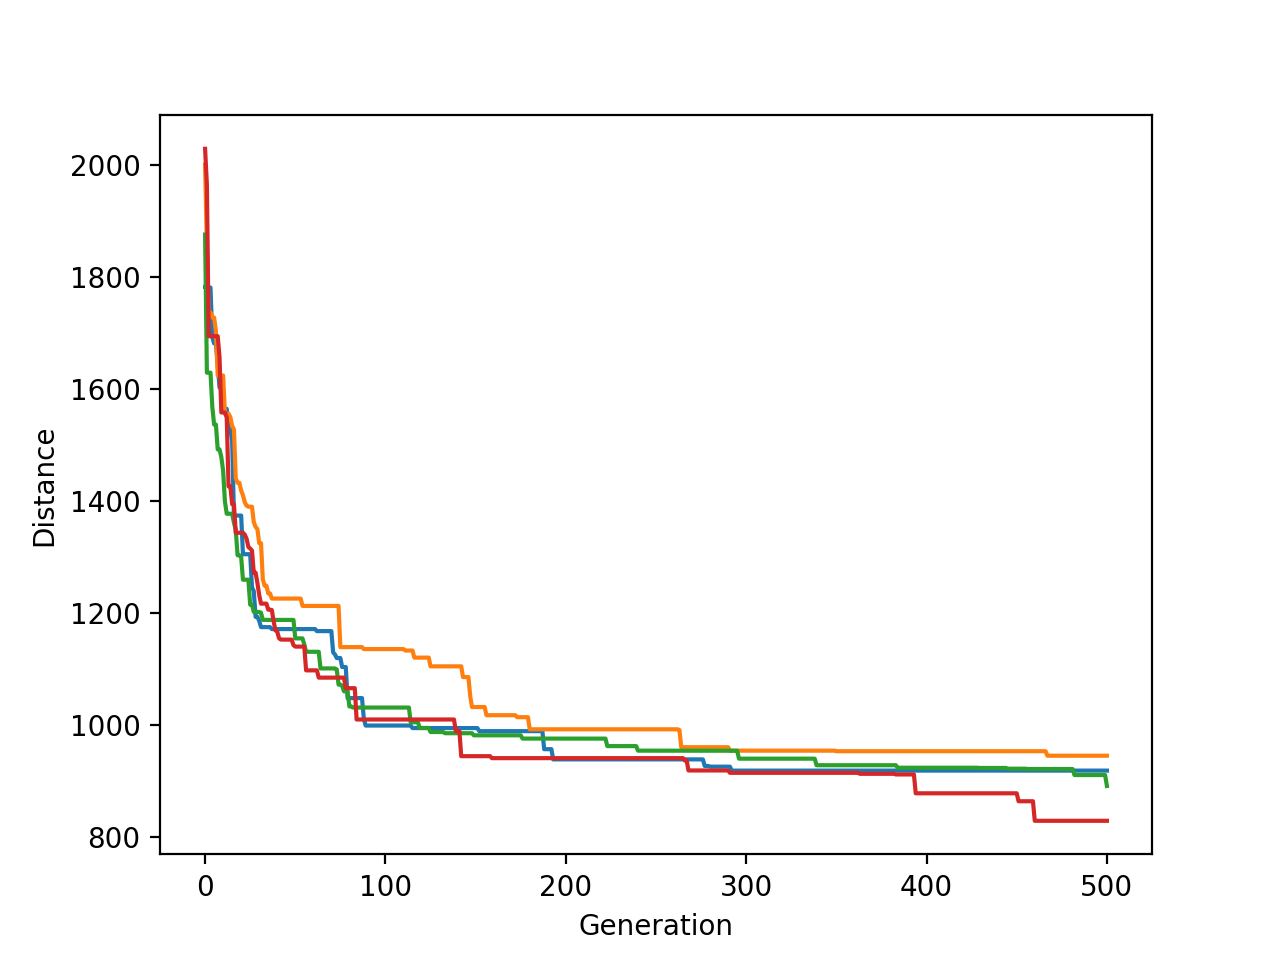

In [173]:
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)


In [174]:
from logProcess import log_progress

ModuleNotFoundError: No module named 'logProcess'

In [177]:
#Generate more data for the graph
geneticAlgorithmPlot(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)

In [ ]:
#Smaller group for testing the adding of methods
geneticAlgorithmPlot(population=cityList[0:10], popSize=20, eliteSize=5, mutationRate=0.01, generations=20)